In [1]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import sys
import matplotlib
from scipy.stats import describe
from scipy.signal import savgol_filter
from imblearn.metrics import classification_report_imbalanced
from imblearn.combine import SMOTETomek, SMOTEENN
from imblearn.under_sampling import EditedNearestNeighbours
import autosklearn.classification
from collections import Counter
import phase_model as pm
from phase_features_loader import PhaseFeaturesLoader
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold
from sklearn.metrics import confusion_matrix

/home/cahya/.virtualenvs/phase/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
dataset_train_big = "data/phase/ml_features.csv"
dataset_train_tiny = "data/phase/ml_features_tiny.csv"
dataset_train = "data/phase/ml_features_train.csv"
dataset_test = "data/phase/ml_features_test.csv"
dataset_train_relabeled = "data/phase/ml_features_train_relabeled.csv"
dataset_test_relabeled = "data/phase/ml_features_test_relabeled.csv"
STA = "URZ"
phases = ["regP", "regS", "tele", "N"]

In [3]:
dff = pd.read_csv(filepath_or_buffer=dataset_train_tiny)
dff.head()

,ARID,STA,TIME,IPHASE,CLASS_IPHASE,PHASE,CLASS_PHASE,RETIME,SOURCE,PER,...,HMXMN,HVRATP,HVRAT,NAB,TAB,HTOV1,HTOV2,HTOV3,HTOV4,HTOV5
0,1582602,LPAZ,9.482724e+08,Lg,regS,Lg,regP,0.000000,M,0.666667,...,1.815760,0.281515,4.312000,0.0,-0.360000,0.672331,2.462823,1.196801,1.564852,0.810008
1,3392748,LPAZ,9.660487e+08,Sn,regS,Lg,regP,2.250001,M,0.333333,...,3.318087,5.777322,3.312782,0.0,0.000000,0.771338,0.658481,2.513435,3.555231,1.341278
2,4251736,LPAZ,9.755992e+08,Lg,regS,Lg,regP,0.549998,M,0.289855,...,5.006600,3.991400,1.593971,-0.1,-0.215000,1.842368,6.353942,0.422784,1.290310,1.712811
3,5843204,LPAZ,9.915611e+08,Lg,regS,Sn,regP,2.170612,M,0.571429,...,2.034370,4.254982,4.254982,0.0,0.000000,1.255465,2.631712,1.016241,2.840468,9.503727
4,6033158,LPAZ,9.934632e+08,Sn,regS,Sn,regP,2.549999,M,0.166667,...,1.822586,1.937456,4.009178,-0.3,-0.453333,0.410712,1.057677,0.842994,1.624028,1.184967


In [4]:
x_indices = ['INANG1', 'INANG3', 'HMXMN', 'HVRATP', 'HVRAT', 'HTOV1', 'HTOV2', 'HTOV3', 'HTOV4', 'HTOV5',
                              'PER', 'RECT', 'PLANS', 'NAB', 'TAB', 'TIME', 'ARID']
phase_length_all = {"URZ": {"regP": 10000, "regS": 10000, "tele": 50000, "N": 500000}}
validation_split = 0.1
batch_size = 1024
# load train dataset
pd_train_all = PhaseFeaturesLoader(filename=dataset_train, validation_split=validation_split, x_indices = x_indices,
                         phase_length=phase_length_all, batch_size=batch_size)

x_train_all, y_train_all = pd_train_all.get_dataset(expand_dim=False, y_onehot=False)

length regP:7151
length regS:6853
length tele:29232
length N:294531


In [5]:
p_counter = [[], [], [], []]
items = sorted(Counter(y_train_all).items())
p_counter = [np.zeros(24*60, dtype="int") for i in phases]
for i, x in enumerate(x_train_all):
    t = int(x_train_all[i, 15])
    try:
        p_counter[y_train_all[i]][t] += 1
    except IndexError:
        print(i, x)

print(np.sum(p_counter))

337767


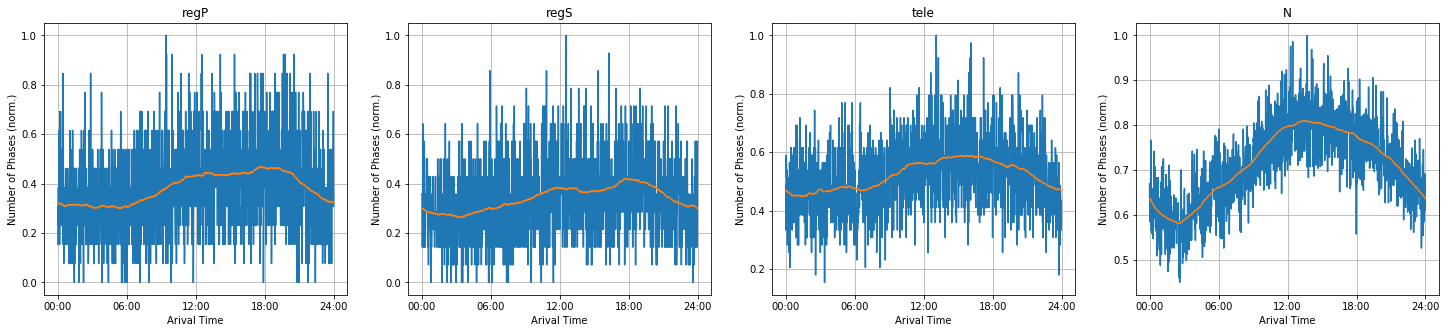

In [6]:
plt.figure(1, figsize=(25, 5))
for i, p in enumerate(phases):
    p_norm = p_counter[i]/describe(p_counter[i]).minmax[1]
    #print(describe(p_counter[i]))
    #print(describe(p_norm))
    ax = plt.subplot(1, 4, i+1)
    yhat = savgol_filter(p_norm, 401, 3, mode="wrap")
    plt.title(p)
    plt.xticks(np.arange(0, 25*60, 60*6), ("00:00", "06:00", "12:00", "18:00", "24:00"))
    plt.xlabel("Arival Time")
    plt.ylabel("Number of Phases (norm.)")
    plt.plot(p_norm)   
    plt.plot(yhat)
    plt.grid(True)
plt.show()

In [7]:
# load train dataset
validation_split = 0.1
batch_size = 1024
phase_length = {"URZ": {"regP": 6840, "regS": 6840, "tele": 6840, "N": 6840*3}}
pd_train = PhaseFeaturesLoader(filename=dataset_train, validation_split=validation_split,
                         phase_length=phase_length, batch_size=batch_size)

x_train, y_train = pd_train.get_dataset(expand_dim=False, y_onehot=False)

length regP:6840
length regS:6840
length tele:6840
length N:20520


In [8]:
# load test dataset
phase_length = {"URZ": {"regP": 2280, "regS": 2280, "tele": 2280, "N": 2280*3}}
pd_test = PhaseFeaturesLoader(filename=dataset_test, phase_length=phase_length, batch_size=batch_size)
x_test, y_test = pd_test.get_dataset(expand_dim=False, y_onehot=False)
print(pd_test.get_phase_index(100089180))

length regP:2280
length regS:2280
length tele:2280
length N:6840
0


In [9]:
#classifiers = ["NN", "SVM", "XGBoost", "GCForest", "AutoML"]
classifiers = ["NN"]
classifier_index = {classifier: i for i, classifier in enumerate(classifiers)}
functions = globals().copy()
classifier_class = {c: getattr(sys.modules["phase_model"], c) for c in classifiers}
print(classifier_class)
print(classifier_index)

{'NN': <class 'phase_model.NN'>}
{'NN': 0}


In [13]:
def run_model_train_predict_all():
    for name in classifiers:
        print(classifier_class[name])
        model = classifier_class[name]()
        sampling_type="nosampling"
        print("model:", model)
        model.fit(x_train, y_train, verbose=1, sampling_type=sampling_type, cv=False)
        model.save("results/phase_train_{}_{}.mdl".format(model.class_name().lower(), sampling_type))
        model.predict(x_test, y_test, sampling_type=sampling_type)

run_model_train_predict_all()

<class 'phase_model.NN'>
model: <phase_model.NN object at 0x7f97de72e668>
Before resampling: [(0, 6840), (1, 6840), (2, 6840), (3, 20520)]
After resampling: [(0, 6840), (1, 6840), (2, 6840), (3, 20520)]
Train on 36936 samples, validate on 4104 samples
Epoch 1/2000
26624/36936 [====================>.........] - ETA: 0s - loss: 8.4963 - acc: 0.4452
Epoch 00001: acc improved from -inf to 0.45660, saving model to results/phase_nn.hdf5
36936/36936 [==============================] - 1s 26us/step - loss: 8.3781 - acc: 0.4566 - val_loss: 8.0220 - val_acc: 0.4963
Epoch 2/2000
26624/36936 [====================>.........] - ETA: 0s - loss: 7.9685 - acc: 0.4950
Epoch 00002: acc improved from 0.45660 to 0.49572, saving model to results/phase_nn.hdf5
36936/36936 [==============================] - 0s 5us/step - loss: 7.9670 - acc: 0.4957 - val_loss: 8.0244 - val_acc: 0.4963
Epoch 3/2000
27648/36936 [=====================>........] - ETA: 0s - loss: 7.9750 - acc: 0.4958
Epoch 00003: acc improved from 

Epoch 30/2000
25600/36936 [===================>..........] - ETA: 0s - loss: 1.2462 - acc: 0.4995
Epoch 00030: acc improved from 0.50038 to 0.50041, saving model to results/phase_nn.hdf5
36936/36936 [==============================] - 0s 5us/step - loss: 1.2459 - acc: 0.5004 - val_loss: 1.2466 - val_acc: 0.4968
Epoch 31/2000
25600/36936 [===================>..........] - ETA: 0s - loss: 1.2450 - acc: 0.4989
Epoch 00031: acc improved from 0.50041 to 0.50060, saving model to results/phase_nn.hdf5
36936/36936 [==============================] - 0s 5us/step - loss: 1.2434 - acc: 0.5006 - val_loss: 1.2455 - val_acc: 0.4971
Epoch 32/2000
26624/36936 [====================>.........] - ETA: 0s - loss: 1.2415 - acc: 0.5014
Epoch 00032: acc improved from 0.50060 to 0.50073, saving model to results/phase_nn.hdf5
36936/36936 [==============================] - 0s 5us/step - loss: 1.2430 - acc: 0.5007 - val_loss: 1.2449 - val_acc: 0.4976
Epoch 33/2000
26624/36936 [====================>.........] - ETA

Epoch 57/2000
26624/36936 [====================>.........] - ETA: 0s - loss: 1.0305 - acc: 0.5814
Epoch 00057: acc improved from 0.57946 to 0.58008, saving model to results/phase_nn.hdf5
36936/36936 [==============================] - 0s 5us/step - loss: 1.0281 - acc: 0.5801 - val_loss: 0.9651 - val_acc: 0.5982
Epoch 58/2000
36864/36936 [============================>.] - ETA: 0s - loss: 1.0247 - acc: 0.5798
Epoch 00058: acc did not improve
36936/36936 [==============================] - 0s 5us/step - loss: 1.0247 - acc: 0.5797 - val_loss: 0.9617 - val_acc: 0.5953
Epoch 59/2000
36864/36936 [============================>.] - ETA: 0s - loss: 1.0250 - acc: 0.5785
Epoch 00059: acc did not improve
36936/36936 [==============================] - 0s 5us/step - loss: 1.0248 - acc: 0.5785 - val_loss: 0.9576 - val_acc: 0.5962
Epoch 60/2000
26624/36936 [====================>.........] - ETA: 0s - loss: 1.0254 - acc: 0.5784
Epoch 00060: acc improved from 0.58008 to 0.58076, saving model to results/pha

Epoch 87/2000
36864/36936 [============================>.] - ETA: 0s - loss: 0.9201 - acc: 0.5955
Epoch 00087: acc improved from 0.59146 to 0.59538, saving model to results/phase_nn.hdf5
36936/36936 [==============================] - 0s 5us/step - loss: 0.9203 - acc: 0.5954 - val_loss: 0.8660 - val_acc: 0.6050
Epoch 88/2000
25600/36936 [===================>..........] - ETA: 0s - loss: 0.9132 - acc: 0.5942
Epoch 00088: acc did not improve
36936/36936 [==============================] - 0s 5us/step - loss: 0.9167 - acc: 0.5932 - val_loss: 0.8636 - val_acc: 0.6099
Epoch 89/2000
25600/36936 [===================>..........] - ETA: 0s - loss: 0.9042 - acc: 0.5998
Epoch 00089: acc improved from 0.59538 to 0.59782, saving model to results/phase_nn.hdf5
36936/36936 [==============================] - 0s 5us/step - loss: 0.9105 - acc: 0.5978 - val_loss: 0.8719 - val_acc: 0.6048
Epoch 90/2000
25600/36936 [===================>..........] - ETA: 0s - loss: 0.9153 - acc: 0.5941
Epoch 00090: acc did n

Epoch 115/2000
26624/36936 [====================>.........] - ETA: 0s - loss: 0.8177 - acc: 0.6535
Epoch 00115: acc did not improve
36936/36936 [==============================] - 0s 4us/step - loss: 0.8217 - acc: 0.6515 - val_loss: 0.7818 - val_acc: 0.6757
Epoch 116/2000
26624/36936 [====================>.........] - ETA: 0s - loss: 0.8216 - acc: 0.6513
Epoch 00116: acc did not improve
36936/36936 [==============================] - 0s 4us/step - loss: 0.8202 - acc: 0.6539 - val_loss: 0.7674 - val_acc: 0.6927
Epoch 117/2000
26624/36936 [====================>.........] - ETA: 0s - loss: 0.8128 - acc: 0.6515
Epoch 00117: acc improved from 0.65410 to 0.65413, saving model to results/phase_nn.hdf5
36936/36936 [==============================] - 0s 5us/step - loss: 0.8104 - acc: 0.6541 - val_loss: 0.7627 - val_acc: 0.6823
Epoch 118/2000
28672/36936 [======================>.......] - ETA: 0s - loss: 0.8068 - acc: 0.6601
Epoch 00118: acc improved from 0.65413 to 0.65882, saving model to results

Epoch 144/2000
36864/36936 [============================>.] - ETA: 0s - loss: 0.7510 - acc: 0.6892
Epoch 00144: acc improved from 0.68908 to 0.68919, saving model to results/phase_nn.hdf5
36936/36936 [==============================] - 0s 5us/step - loss: 0.7511 - acc: 0.6892 - val_loss: 0.7279 - val_acc: 0.7025
Epoch 145/2000
36864/36936 [============================>.] - ETA: 0s - loss: 0.7588 - acc: 0.6851
Epoch 00145: acc did not improve
36936/36936 [==============================] - 0s 5us/step - loss: 0.7587 - acc: 0.6852 - val_loss: 0.7107 - val_acc: 0.7171
Epoch 146/2000
36864/36936 [============================>.] - ETA: 0s - loss: 0.7483 - acc: 0.6883
Epoch 00146: acc did not improve
36936/36936 [==============================] - 0s 5us/step - loss: 0.7484 - acc: 0.6884 - val_loss: 0.7193 - val_acc: 0.7127
Epoch 147/2000
26624/36936 [====================>.........] - ETA: 0s - loss: 0.7518 - acc: 0.6899
Epoch 00147: acc improved from 0.68919 to 0.69025, saving model to results

Epoch 174/2000
35840/36936 [============================>.] - ETA: 0s - loss: 0.7324 - acc: 0.7008
Epoch 00174: acc did not improve
36936/36936 [==============================] - 0s 5us/step - loss: 0.7326 - acc: 0.7009 - val_loss: 0.6969 - val_acc: 0.7225
Epoch 175/2000
25600/36936 [===================>..........] - ETA: 0s - loss: 0.7379 - acc: 0.6948
Epoch 00175: acc did not improve
36936/36936 [==============================] - 0s 5us/step - loss: 0.7357 - acc: 0.6962 - val_loss: 0.7106 - val_acc: 0.7144
Epoch 176/2000
25600/36936 [===================>..........] - ETA: 0s - loss: 0.7340 - acc: 0.7004
Epoch 00176: acc did not improve
36936/36936 [==============================] - 0s 4us/step - loss: 0.7312 - acc: 0.7014 - val_loss: 0.6967 - val_acc: 0.7193
Epoch 177/2000
35840/36936 [============================>.] - ETA: 0s - loss: 0.7255 - acc: 0.7012
Epoch 00177: acc did not improve
36936/36936 [==============================] - 0s 5us/step - loss: 0.7258 - acc: 0.7012 - val_los

26624/36936 [====================>.........] - ETA: 0s - loss: 0.7129 - acc: 0.7081
Epoch 00204: acc did not improve
36936/36936 [==============================] - 0s 5us/step - loss: 0.7122 - acc: 0.7081 - val_loss: 0.6962 - val_acc: 0.7188
Epoch 205/2000
26624/36936 [====================>.........] - ETA: 0s - loss: 0.7097 - acc: 0.7086
Epoch 00205: acc did not improve
36936/36936 [==============================] - 0s 5us/step - loss: 0.7088 - acc: 0.7089 - val_loss: 0.6868 - val_acc: 0.7232
Epoch 206/2000
25600/36936 [===================>..........] - ETA: 0s - loss: 0.7009 - acc: 0.7128
Epoch 00206: acc improved from 0.71112 to 0.71188, saving model to results/phase_nn.hdf5
36936/36936 [==============================] - 0s 5us/step - loss: 0.7053 - acc: 0.7119 - val_loss: 0.6932 - val_acc: 0.7164
Epoch 207/2000
36864/36936 [============================>.] - ETA: 0s - loss: 0.7116 - acc: 0.7095
Epoch 00207: acc did not improve
36936/36936 [==============================] - 0s 5us/st

Epoch 235/2000
36864/36936 [============================>.] - ETA: 0s - loss: 0.7092 - acc: 0.7070
Epoch 00235: acc did not improve
36936/36936 [==============================] - 0s 5us/step - loss: 0.7092 - acc: 0.7071 - val_loss: 0.6894 - val_acc: 0.7193
Epoch 236/2000
24576/36936 [==================>...........] - ETA: 0s - loss: 0.7029 - acc: 0.7133
Epoch 00236: acc did not improve
36936/36936 [==============================] - 0s 5us/step - loss: 0.6994 - acc: 0.7146 - val_loss: 0.6802 - val_acc: 0.7227
Epoch 237/2000
26624/36936 [====================>.........] - ETA: 0s - loss: 0.6965 - acc: 0.7168
Epoch 00237: acc did not improve
36936/36936 [==============================] - 0s 4us/step - loss: 0.6985 - acc: 0.7158 - val_loss: 0.6860 - val_acc: 0.7242
Epoch 238/2000
26624/36936 [====================>.........] - ETA: 0s - loss: 0.7051 - acc: 0.7103
Epoch 00238: acc did not improve
36936/36936 [==============================] - 0s 4us/step - loss: 0.7044 - acc: 0.7112 - val_los

Epoch 267/2000
27648/36936 [=====================>........] - ETA: 0s - loss: 0.6953 - acc: 0.7135
Epoch 00267: acc did not improve
36936/36936 [==============================] - 0s 4us/step - loss: 0.6936 - acc: 0.7152 - val_loss: 0.6788 - val_acc: 0.7303
Epoch 268/2000
25600/36936 [===================>..........] - ETA: 0s - loss: 0.6937 - acc: 0.7184
Epoch 00268: acc did not improve
36936/36936 [==============================] - 0s 4us/step - loss: 0.6972 - acc: 0.7166 - val_loss: 0.6759 - val_acc: 0.7288
Epoch 269/2000
27648/36936 [=====================>........] - ETA: 0s - loss: 0.7029 - acc: 0.7121
Epoch 00269: acc did not improve
36936/36936 [==============================] - 0s 4us/step - loss: 0.6989 - acc: 0.7147 - val_loss: 0.6827 - val_acc: 0.7271
Epoch 270/2000
27648/36936 [=====================>........] - ETA: 0s - loss: 0.6995 - acc: 0.7121
Epoch 00270: acc did not improve
36936/36936 [==============================] - 0s 4us/step - loss: 0.6992 - acc: 0.7127 - val_los

27648/36936 [=====================>........] - ETA: 0s - loss: 0.6875 - acc: 0.7203
Epoch 00298: acc did not improve
36936/36936 [==============================] - 0s 4us/step - loss: 0.6884 - acc: 0.7196 - val_loss: 0.6748 - val_acc: 0.7288
Epoch 299/2000
25600/36936 [===================>..........] - ETA: 0s - loss: 0.6936 - acc: 0.7145
Epoch 00299: acc did not improve
36936/36936 [==============================] - 0s 4us/step - loss: 0.6902 - acc: 0.7158 - val_loss: 0.6670 - val_acc: 0.7349
Epoch 300/2000
26624/36936 [====================>.........] - ETA: 0s - loss: 0.6932 - acc: 0.7180
Epoch 00300: acc did not improve
36936/36936 [==============================] - 0s 5us/step - loss: 0.6913 - acc: 0.7188 - val_loss: 0.6768 - val_acc: 0.7276
Epoch 301/2000
26624/36936 [====================>.........] - ETA: 0s - loss: 0.6924 - acc: 0.7137
Epoch 00301: acc did not improve
36936/36936 [==============================] - 0s 4us/step - loss: 0.6888 - acc: 0.7175 - val_loss: 0.6734 - val

25600/36936 [===================>..........] - ETA: 0s - loss: 0.6777 - acc: 0.7234
Epoch 00329: acc improved from 0.72333 to 0.72436, saving model to results/phase_nn.hdf5
36936/36936 [==============================] - 0s 5us/step - loss: 0.6808 - acc: 0.7244 - val_loss: 0.6690 - val_acc: 0.7220
Epoch 330/2000
24576/36936 [==================>...........] - ETA: 0s - loss: 0.6893 - acc: 0.7183
Epoch 00330: acc did not improve
36936/36936 [==============================] - 0s 5us/step - loss: 0.6863 - acc: 0.7188 - val_loss: 0.6693 - val_acc: 0.7286
Epoch 331/2000
26624/36936 [====================>.........] - ETA: 0s - loss: 0.6884 - acc: 0.7198
Epoch 00331: acc did not improve
36936/36936 [==============================] - 0s 5us/step - loss: 0.6850 - acc: 0.7217 - val_loss: 0.6804 - val_acc: 0.7191
Epoch 332/2000
26624/36936 [====================>.........] - ETA: 0s - loss: 0.6946 - acc: 0.7138
Epoch 00332: acc did not improve
36936/36936 [==============================] - 0s 4us/st

Epoch 361/2000
26624/36936 [====================>.........] - ETA: 0s - loss: 0.6850 - acc: 0.7183
Epoch 00361: acc did not improve
36936/36936 [==============================] - 0s 4us/step - loss: 0.6817 - acc: 0.7203 - val_loss: 0.6633 - val_acc: 0.7293
Epoch 362/2000
27648/36936 [=====================>........] - ETA: 0s - loss: 0.6777 - acc: 0.7207
Epoch 00362: acc did not improve
36936/36936 [==============================] - 0s 4us/step - loss: 0.6791 - acc: 0.7210 - val_loss: 0.6629 - val_acc: 0.7295
Epoch 363/2000
26624/36936 [====================>.........] - ETA: 0s - loss: 0.6811 - acc: 0.7201
Epoch 00363: acc did not improve
36936/36936 [==============================] - 0s 4us/step - loss: 0.6808 - acc: 0.7208 - val_loss: 0.6881 - val_acc: 0.7066
Epoch 364/2000
25600/36936 [===================>..........] - ETA: 0s - loss: 0.6858 - acc: 0.7169
Epoch 00364: acc did not improve
36936/36936 [==============================] - 0s 4us/step - loss: 0.6818 - acc: 0.7207 - val_los

Epoch 393/2000
25600/36936 [===================>..........] - ETA: 0s - loss: 0.6790 - acc: 0.7230
Epoch 00393: acc did not improve
36936/36936 [==============================] - 0s 5us/step - loss: 0.6799 - acc: 0.7241 - val_loss: 0.6690 - val_acc: 0.7276
Epoch 394/2000
25600/36936 [===================>..........] - ETA: 0s - loss: 0.6877 - acc: 0.7199
Epoch 00394: acc did not improve
36936/36936 [==============================] - 0s 4us/step - loss: 0.6833 - acc: 0.7223 - val_loss: 0.6641 - val_acc: 0.7325
Epoch 395/2000
24576/36936 [==================>...........] - ETA: 0s - loss: 0.6734 - acc: 0.7240
Epoch 00395: acc did not improve
36936/36936 [==============================] - 0s 5us/step - loss: 0.6795 - acc: 0.7226 - val_loss: 0.6668 - val_acc: 0.7290
Epoch 396/2000
36864/36936 [============================>.] - ETA: 0s - loss: 0.6862 - acc: 0.7195
Epoch 00396: acc did not improve
36936/36936 [==============================] - 0s 5us/step - loss: 0.6861 - acc: 0.7196 - val_los

Epoch 425/2000
26624/36936 [====================>.........] - ETA: 0s - loss: 0.6812 - acc: 0.7238
Epoch 00425: acc did not improve
36936/36936 [==============================] - 0s 4us/step - loss: 0.6776 - acc: 0.7237 - val_loss: 0.6620 - val_acc: 0.7310
Epoch 426/2000
29696/36936 [=======================>......] - ETA: 0s - loss: 0.6785 - acc: 0.7241
Epoch 00426: acc did not improve
36936/36936 [==============================] - 0s 4us/step - loss: 0.6767 - acc: 0.7240 - val_loss: 0.6582 - val_acc: 0.7339
Epoch 427/2000
26624/36936 [====================>.........] - ETA: 0s - loss: 0.6742 - acc: 0.7259
Epoch 00427: acc did not improve
36936/36936 [==============================] - 0s 4us/step - loss: 0.6743 - acc: 0.7239 - val_loss: 0.6601 - val_acc: 0.7290
Epoch 428/2000
27648/36936 [=====================>........] - ETA: 0s - loss: 0.6766 - acc: 0.7252
Epoch 00428: acc did not improve
36936/36936 [==============================] - 0s 4us/step - loss: 0.6742 - acc: 0.7258 - val_los

Epoch 457/2000
25600/36936 [===================>..........] - ETA: 0s - loss: 0.6770 - acc: 0.7223
Epoch 00457: acc did not improve
36936/36936 [==============================] - 0s 4us/step - loss: 0.6775 - acc: 0.7233 - val_loss: 0.6517 - val_acc: 0.7410
Epoch 458/2000
27648/36936 [=====================>........] - ETA: 0s - loss: 0.6732 - acc: 0.7264
Epoch 00458: acc did not improve
36936/36936 [==============================] - 0s 4us/step - loss: 0.6704 - acc: 0.7262 - val_loss: 0.6520 - val_acc: 0.7398
Epoch 459/2000
25600/36936 [===================>..........] - ETA: 0s - loss: 0.6687 - acc: 0.7281
Epoch 00459: acc did not improve
36936/36936 [==============================] - 0s 4us/step - loss: 0.6678 - acc: 0.7284 - val_loss: 0.6593 - val_acc: 0.7339
Epoch 460/2000
27648/36936 [=====================>........] - ETA: 0s - loss: 0.6644 - acc: 0.7301
Epoch 00460: acc improved from 0.72845 to 0.73116, saving model to results/phase_nn.hdf5
36936/36936 [============================

Epoch 489/2000
26624/36936 [====================>.........] - ETA: 0s - loss: 0.6792 - acc: 0.7245
Epoch 00489: acc did not improve
36936/36936 [==============================] - 0s 4us/step - loss: 0.6748 - acc: 0.7258 - val_loss: 0.6604 - val_acc: 0.7327
Epoch 490/2000
26624/36936 [====================>.........] - ETA: 0s - loss: 0.6770 - acc: 0.7243
Epoch 00490: acc did not improve
36936/36936 [==============================] - 0s 4us/step - loss: 0.6773 - acc: 0.7240 - val_loss: 0.6682 - val_acc: 0.7283
Epoch 491/2000
26624/36936 [====================>.........] - ETA: 0s - loss: 0.6807 - acc: 0.7216
Epoch 00491: acc did not improve
36936/36936 [==============================] - 0s 4us/step - loss: 0.6811 - acc: 0.7220 - val_loss: 0.6548 - val_acc: 0.7312
Epoch 492/2000
26624/36936 [====================>.........] - ETA: 0s - loss: 0.6738 - acc: 0.7254
Epoch 00492: acc did not improve
36936/36936 [==============================] - 0s 5us/step - loss: 0.6769 - acc: 0.7245 - val_los

Epoch 521/2000
26624/36936 [====================>.........] - ETA: 0s - loss: 0.6833 - acc: 0.7230
Epoch 00521: acc did not improve
36936/36936 [==============================] - 0s 5us/step - loss: 0.6800 - acc: 0.7243 - val_loss: 0.6613 - val_acc: 0.7264
Epoch 522/2000
36864/36936 [============================>.] - ETA: 0s - loss: 0.6709 - acc: 0.7252
Epoch 00522: acc did not improve
36936/36936 [==============================] - 0s 5us/step - loss: 0.6710 - acc: 0.7252 - val_loss: 0.6735 - val_acc: 0.7125
Epoch 523/2000
25600/36936 [===================>..........] - ETA: 0s - loss: 0.6766 - acc: 0.7227
Epoch 00523: acc did not improve
36936/36936 [==============================] - 0s 4us/step - loss: 0.6731 - acc: 0.7256 - val_loss: 0.6555 - val_acc: 0.7371
Epoch 524/2000
24576/36936 [==================>...........] - ETA: 0s - loss: 0.6724 - acc: 0.7245
Epoch 00524: acc did not improve
36936/36936 [==============================] - 0s 5us/step - loss: 0.6753 - acc: 0.7246 - val_los

Epoch 553/2000
25600/36936 [===================>..........] - ETA: 0s - loss: 0.6635 - acc: 0.7296
Epoch 00553: acc did not improve
36936/36936 [==============================] - 0s 4us/step - loss: 0.6667 - acc: 0.7289 - val_loss: 0.6868 - val_acc: 0.7149
Epoch 554/2000
25600/36936 [===================>..........] - ETA: 0s - loss: 0.6785 - acc: 0.7223
Epoch 00554: acc did not improve
36936/36936 [==============================] - 0s 5us/step - loss: 0.6812 - acc: 0.7205 - val_loss: 0.6580 - val_acc: 0.7337
Epoch 555/2000
26624/36936 [====================>.........] - ETA: 0s - loss: 0.6716 - acc: 0.7249
Epoch 00555: acc did not improve
36936/36936 [==============================] - 0s 4us/step - loss: 0.6705 - acc: 0.7261 - val_loss: 0.6524 - val_acc: 0.7400
Epoch 556/2000
26624/36936 [====================>.........] - ETA: 0s - loss: 0.6645 - acc: 0.7275
Epoch 00556: acc did not improve
36936/36936 [==============================] - 0s 4us/step - loss: 0.6702 - acc: 0.7256 - val_los

Epoch 585/2000
26624/36936 [====================>.........] - ETA: 0s - loss: 0.6705 - acc: 0.7302
Epoch 00585: acc did not improve
36936/36936 [==============================] - 0s 4us/step - loss: 0.6701 - acc: 0.7296 - val_loss: 0.6589 - val_acc: 0.7317
Epoch 586/2000
25600/36936 [===================>..........] - ETA: 0s - loss: 0.6742 - acc: 0.7268
Epoch 00586: acc did not improve
36936/36936 [==============================] - 0s 5us/step - loss: 0.6732 - acc: 0.7268 - val_loss: 0.6570 - val_acc: 0.7344
Epoch 587/2000
25600/36936 [===================>..........] - ETA: 0s - loss: 0.6725 - acc: 0.7232
Epoch 00587: acc did not improve
36936/36936 [==============================] - 0s 5us/step - loss: 0.6732 - acc: 0.7251 - val_loss: 0.6587 - val_acc: 0.7320
Epoch 588/2000
36864/36936 [============================>.] - ETA: 0s - loss: 0.6744 - acc: 0.7260
Epoch 00588: acc did not improve
36936/36936 [==============================] - 0s 5us/step - loss: 0.6741 - acc: 0.7260 - val_los

Epoch 617/2000
25600/36936 [===================>..........] - ETA: 0s - loss: 0.6655 - acc: 0.7281
Epoch 00617: acc did not improve
36936/36936 [==============================] - 0s 5us/step - loss: 0.6664 - acc: 0.7278 - val_loss: 0.6473 - val_acc: 0.7388
Epoch 618/2000
36864/36936 [============================>.] - ETA: 0s - loss: 0.6662 - acc: 0.7304
Epoch 00618: acc did not improve
36936/36936 [==============================] - 0s 5us/step - loss: 0.6662 - acc: 0.7303 - val_loss: 0.6545 - val_acc: 0.7385
Epoch 619/2000
27648/36936 [=====================>........] - ETA: 0s - loss: 0.6705 - acc: 0.7270
Epoch 00619: acc did not improve
36936/36936 [==============================] - 0s 4us/step - loss: 0.6694 - acc: 0.7286 - val_loss: 0.6637 - val_acc: 0.7281
Epoch 620/2000
26624/36936 [====================>.........] - ETA: 0s - loss: 0.6781 - acc: 0.7208
Epoch 00620: acc did not improve
36936/36936 [==============================] - 0s 4us/step - loss: 0.6723 - acc: 0.7237 - val_los

Epoch 649/2000
25600/36936 [===================>..........] - ETA: 0s - loss: 0.6701 - acc: 0.7295
Epoch 00649: acc did not improve
36936/36936 [==============================] - 0s 4us/step - loss: 0.6694 - acc: 0.7290 - val_loss: 0.6585 - val_acc: 0.7303
Epoch 650/2000
36864/36936 [============================>.] - ETA: 0s - loss: 0.6693 - acc: 0.7243
Epoch 00650: acc did not improve
36936/36936 [==============================] - 0s 5us/step - loss: 0.6693 - acc: 0.7242 - val_loss: 0.6558 - val_acc: 0.7351
Epoch 651/2000
26624/36936 [====================>.........] - ETA: 0s - loss: 0.6647 - acc: 0.7325
Epoch 00651: acc improved from 0.73143 to 0.73281, saving model to results/phase_nn.hdf5
36936/36936 [==============================] - 0s 5us/step - loss: 0.6621 - acc: 0.7328 - val_loss: 0.6560 - val_acc: 0.7388
Epoch 652/2000
25600/36936 [===================>..........] - ETA: 0s - loss: 0.6645 - acc: 0.7275
Epoch 00652: acc did not improve
36936/36936 [============================

Epoch 681/2000
27648/36936 [=====================>........] - ETA: 0s - loss: 0.6636 - acc: 0.7303
Epoch 00681: acc did not improve
36936/36936 [==============================] - 0s 4us/step - loss: 0.6650 - acc: 0.7290 - val_loss: 0.6551 - val_acc: 0.7349
Epoch 682/2000
26624/36936 [====================>.........] - ETA: 0s - loss: 0.6701 - acc: 0.7258
Epoch 00682: acc did not improve
36936/36936 [==============================] - 0s 4us/step - loss: 0.6649 - acc: 0.7285 - val_loss: 0.6473 - val_acc: 0.7373
Epoch 683/2000
25600/36936 [===================>..........] - ETA: 0s - loss: 0.6611 - acc: 0.7345
Epoch 00683: acc did not improve
36936/36936 [==============================] - 0s 4us/step - loss: 0.6633 - acc: 0.7318 - val_loss: 0.6552 - val_acc: 0.7342
Epoch 684/2000
27648/36936 [=====================>........] - ETA: 0s - loss: 0.6610 - acc: 0.7305
Epoch 00684: acc did not improve
36936/36936 [==============================] - 0s 4us/step - loss: 0.6626 - acc: 0.7304 - val_los

Epoch 713/2000
26624/36936 [====================>.........] - ETA: 0s - loss: 0.6739 - acc: 0.7268
Epoch 00713: acc did not improve
36936/36936 [==============================] - 0s 5us/step - loss: 0.6710 - acc: 0.7275 - val_loss: 0.6571 - val_acc: 0.7308
Epoch 714/2000
36864/36936 [============================>.] - ETA: 0s - loss: 0.6656 - acc: 0.7284
Epoch 00714: acc did not improve
36936/36936 [==============================] - 0s 5us/step - loss: 0.6659 - acc: 0.7283 - val_loss: 0.6478 - val_acc: 0.7385
Epoch 715/2000
27648/36936 [=====================>........] - ETA: 0s - loss: 0.6704 - acc: 0.7284
Epoch 00715: acc did not improve
36936/36936 [==============================] - 0s 4us/step - loss: 0.6664 - acc: 0.7287 - val_loss: 0.6561 - val_acc: 0.7315
Epoch 716/2000
26624/36936 [====================>.........] - ETA: 0s - loss: 0.6627 - acc: 0.7314
Epoch 00716: acc did not improve
36936/36936 [==============================] - 0s 4us/step - loss: 0.6647 - acc: 0.7300 - val_los

Epoch 745/2000
25600/36936 [===================>..........] - ETA: 0s - loss: 0.6676 - acc: 0.7262
Epoch 00745: acc did not improve
36936/36936 [==============================] - 0s 5us/step - loss: 0.6612 - acc: 0.7295 - val_loss: 0.6750 - val_acc: 0.7312
Epoch 746/2000
26624/36936 [====================>.........] - ETA: 0s - loss: 0.6813 - acc: 0.7218
Epoch 00746: acc did not improve
36936/36936 [==============================] - 0s 4us/step - loss: 0.6829 - acc: 0.7218 - val_loss: 0.6592 - val_acc: 0.7368
Epoch 747/2000
27648/36936 [=====================>........] - ETA: 0s - loss: 0.6734 - acc: 0.7241
Epoch 00747: acc did not improve
36936/36936 [==============================] - 0s 4us/step - loss: 0.6724 - acc: 0.7250 - val_loss: 0.6556 - val_acc: 0.7346
Epoch 748/2000
36864/36936 [============================>.] - ETA: 0s - loss: 0.6686 - acc: 0.7293
Epoch 00748: acc did not improve
36936/36936 [==============================] - 0s 5us/step - loss: 0.6689 - acc: 0.7291 - val_los

Epoch 777/2000
25600/36936 [===================>..........] - ETA: 0s - loss: 0.6725 - acc: 0.7263
Epoch 00777: acc did not improve
36936/36936 [==============================] - 0s 5us/step - loss: 0.6758 - acc: 0.7260 - val_loss: 0.6563 - val_acc: 0.7339
Epoch 778/2000
26624/36936 [====================>.........] - ETA: 0s - loss: 0.6708 - acc: 0.7253
Epoch 00778: acc did not improve
36936/36936 [==============================] - 0s 4us/step - loss: 0.6696 - acc: 0.7254 - val_loss: 0.6691 - val_acc: 0.7349
Epoch 779/2000
25600/36936 [===================>..........] - ETA: 0s - loss: 0.6688 - acc: 0.7258
Epoch 00779: acc did not improve
36936/36936 [==============================] - 0s 4us/step - loss: 0.6703 - acc: 0.7264 - val_loss: 0.6639 - val_acc: 0.7351
Epoch 780/2000
27648/36936 [=====================>........] - ETA: 0s - loss: 0.6667 - acc: 0.7284
Epoch 00780: acc did not improve
36936/36936 [==============================] - 0s 4us/step - loss: 0.6669 - acc: 0.7292 - val_los

Epoch 809/2000
25600/36936 [===================>..........] - ETA: 0s - loss: 0.6695 - acc: 0.7257
Epoch 00809: acc did not improve
36936/36936 [==============================] - 0s 5us/step - loss: 0.6643 - acc: 0.7290 - val_loss: 0.6566 - val_acc: 0.7281
Epoch 810/2000
28672/36936 [======================>.......] - ETA: 0s - loss: 0.6654 - acc: 0.7284
Epoch 00810: acc did not improve
36936/36936 [==============================] - 0s 4us/step - loss: 0.6619 - acc: 0.7304 - val_loss: 0.6470 - val_acc: 0.7385
Epoch 811/2000
35840/36936 [============================>.] - ETA: 0s - loss: 0.6596 - acc: 0.7307
Epoch 00811: acc did not improve
36936/36936 [==============================] - 0s 5us/step - loss: 0.6592 - acc: 0.7307 - val_loss: 0.6492 - val_acc: 0.7376
Epoch 812/2000
25600/36936 [===================>..........] - ETA: 0s - loss: 0.6609 - acc: 0.7319
Epoch 00812: acc did not improve
36936/36936 [==============================] - 0s 5us/step - loss: 0.6604 - acc: 0.7316 - val_los

Epoch 841/2000
26624/36936 [====================>.........] - ETA: 0s - loss: 0.6622 - acc: 0.7298
Epoch 00841: acc did not improve
36936/36936 [==============================] - 0s 5us/step - loss: 0.6596 - acc: 0.7312 - val_loss: 0.6575 - val_acc: 0.7337
Epoch 842/2000
35840/36936 [============================>.] - ETA: 0s - loss: 0.6652 - acc: 0.7297
Epoch 00842: acc did not improve
36936/36936 [==============================] - 0s 5us/step - loss: 0.6647 - acc: 0.7297 - val_loss: 0.6509 - val_acc: 0.7437
Epoch 843/2000
26624/36936 [====================>.........] - ETA: 0s - loss: 0.6704 - acc: 0.7254
Epoch 00843: acc did not improve
36936/36936 [==============================] - 0s 5us/step - loss: 0.6697 - acc: 0.7276 - val_loss: 0.6490 - val_acc: 0.7393
Epoch 844/2000
25600/36936 [===================>..........] - ETA: 0s - loss: 0.6681 - acc: 0.7320
Epoch 00844: acc did not improve
36936/36936 [==============================] - 0s 5us/step - loss: 0.6668 - acc: 0.7319 - val_los

Epoch 873/2000
27648/36936 [=====================>........] - ETA: 0s - loss: 0.6597 - acc: 0.7329
Epoch 00873: acc did not improve
36936/36936 [==============================] - 0s 4us/step - loss: 0.6578 - acc: 0.7333 - val_loss: 0.6527 - val_acc: 0.7356
Epoch 874/2000
25600/36936 [===================>..........] - ETA: 0s - loss: 0.6630 - acc: 0.7332
Epoch 00874: acc improved from 0.73343 to 0.73381, saving model to results/phase_nn.hdf5
36936/36936 [==============================] - 0s 5us/step - loss: 0.6606 - acc: 0.7338 - val_loss: 0.6602 - val_acc: 0.7373
Epoch 875/2000
26624/36936 [====================>.........] - ETA: 0s - loss: 0.6625 - acc: 0.7298
Epoch 00875: acc did not improve
36936/36936 [==============================] - 0s 4us/step - loss: 0.6611 - acc: 0.7327 - val_loss: 0.6472 - val_acc: 0.7388
Epoch 876/2000
27648/36936 [=====================>........] - ETA: 0s - loss: 0.6602 - acc: 0.7314
Epoch 00876: acc did not improve
36936/36936 [============================

Epoch 905/2000
26624/36936 [====================>.........] - ETA: 0s - loss: 0.6667 - acc: 0.7268
Epoch 00905: acc did not improve
36936/36936 [==============================] - 0s 4us/step - loss: 0.6631 - acc: 0.7292 - val_loss: 0.6638 - val_acc: 0.7354
Epoch 906/2000
27648/36936 [=====================>........] - ETA: 0s - loss: 0.6803 - acc: 0.7216
Epoch 00906: acc did not improve
36936/36936 [==============================] - 0s 4us/step - loss: 0.6749 - acc: 0.7241 - val_loss: 0.6690 - val_acc: 0.7249
Epoch 907/2000
26624/36936 [====================>.........] - ETA: 0s - loss: 0.6691 - acc: 0.7276
Epoch 00907: acc did not improve
36936/36936 [==============================] - 0s 4us/step - loss: 0.6688 - acc: 0.7278 - val_loss: 0.6514 - val_acc: 0.7385
Epoch 908/2000
25600/36936 [===================>..........] - ETA: 0s - loss: 0.6633 - acc: 0.7316
Epoch 00908: acc did not improve
36936/36936 [==============================] - 0s 5us/step - loss: 0.6614 - acc: 0.7324 - val_los

Epoch 937/2000
27648/36936 [=====================>........] - ETA: 0s - loss: 0.6667 - acc: 0.7312
Epoch 00937: acc did not improve
36936/36936 [==============================] - 0s 4us/step - loss: 0.6674 - acc: 0.7309 - val_loss: 0.6517 - val_acc: 0.7346
Epoch 938/2000
25600/36936 [===================>..........] - ETA: 0s - loss: 0.6641 - acc: 0.7298
Epoch 00938: acc did not improve
36936/36936 [==============================] - 0s 4us/step - loss: 0.6664 - acc: 0.7290 - val_loss: 0.6612 - val_acc: 0.7356
Epoch 939/2000
36864/36936 [============================>.] - ETA: 0s - loss: 0.6631 - acc: 0.7302
Epoch 00939: acc did not improve
36936/36936 [==============================] - 0s 5us/step - loss: 0.6633 - acc: 0.7301 - val_loss: 0.6520 - val_acc: 0.7390
Epoch 940/2000
25600/36936 [===================>..........] - ETA: 0s - loss: 0.6636 - acc: 0.7285
Epoch 00940: acc did not improve
36936/36936 [==============================] - 0s 4us/step - loss: 0.6652 - acc: 0.7298 - val_los

Epoch 969/2000
27648/36936 [=====================>........] - ETA: 0s - loss: 0.6776 - acc: 0.7259
Epoch 00969: acc did not improve
36936/36936 [==============================] - 0s 4us/step - loss: 0.6734 - acc: 0.7269 - val_loss: 0.6638 - val_acc: 0.7242
Epoch 970/2000
26624/36936 [====================>.........] - ETA: 0s - loss: 0.6697 - acc: 0.7283
Epoch 00970: acc did not improve
36936/36936 [==============================] - 0s 4us/step - loss: 0.6669 - acc: 0.7287 - val_loss: 0.6545 - val_acc: 0.7417
Epoch 971/2000
26624/36936 [====================>.........] - ETA: 0s - loss: 0.6651 - acc: 0.7279
Epoch 00971: acc did not improve
36936/36936 [==============================] - 0s 4us/step - loss: 0.6652 - acc: 0.7279 - val_loss: 0.6544 - val_acc: 0.7359
Epoch 972/2000
25600/36936 [===================>..........] - ETA: 0s - loss: 0.6603 - acc: 0.7329
Epoch 00972: acc did not improve
36936/36936 [==============================] - 0s 4us/step - loss: 0.6618 - acc: 0.7310 - val_los

Epoch 1001/2000
25600/36936 [===================>..........] - ETA: 0s - loss: 0.6605 - acc: 0.7299
Epoch 01001: acc did not improve
36936/36936 [==============================] - 0s 5us/step - loss: 0.6604 - acc: 0.7310 - val_loss: 0.6539 - val_acc: 0.7456
Epoch 1002/2000
25600/36936 [===================>..........] - ETA: 0s - loss: 0.6735 - acc: 0.7277
Epoch 01002: acc did not improve
36936/36936 [==============================] - 0s 5us/step - loss: 0.6670 - acc: 0.7293 - val_loss: 0.6458 - val_acc: 0.7420
Epoch 1003/2000
25600/36936 [===================>..........] - ETA: 0s - loss: 0.6647 - acc: 0.7287
Epoch 01003: acc did not improve
36936/36936 [==============================] - 0s 4us/step - loss: 0.6647 - acc: 0.7302 - val_loss: 0.6759 - val_acc: 0.7288
Epoch 1004/2000
27648/36936 [=====================>........] - ETA: 0s - loss: 0.6704 - acc: 0.7298
Epoch 01004: acc did not improve
36936/36936 [==============================] - 0s 4us/step - loss: 0.6709 - acc: 0.7280 - val

Epoch 1033/2000
26624/36936 [====================>.........] - ETA: 0s - loss: 0.6637 - acc: 0.7284
Epoch 01033: acc did not improve
36936/36936 [==============================] - 0s 5us/step - loss: 0.6625 - acc: 0.7300 - val_loss: 0.6473 - val_acc: 0.7446
Epoch 1034/2000
25600/36936 [===================>..........] - ETA: 0s - loss: 0.6585 - acc: 0.7323
Epoch 01034: acc did not improve
36936/36936 [==============================] - 0s 5us/step - loss: 0.6589 - acc: 0.7325 - val_loss: 0.6497 - val_acc: 0.7424
Epoch 1035/2000
24576/36936 [==================>...........] - ETA: 0s - loss: 0.6664 - acc: 0.7285
Epoch 01035: acc did not improve
36936/36936 [==============================] - 0s 5us/step - loss: 0.6630 - acc: 0.7303 - val_loss: 0.6481 - val_acc: 0.7427
Epoch 1036/2000
36864/36936 [============================>.] - ETA: 0s - loss: 0.6596 - acc: 0.7311
Epoch 01036: acc did not improve
36936/36936 [==============================] - 0s 5us/step - loss: 0.6594 - acc: 0.7312 - val

Epoch 1065/2000
36864/36936 [============================>.] - ETA: 0s - loss: 0.6564 - acc: 0.7349
Epoch 01065: acc did not improve
36936/36936 [==============================] - 0s 5us/step - loss: 0.6564 - acc: 0.7349 - val_loss: 0.6426 - val_acc: 0.7466
Epoch 1066/2000
26624/36936 [====================>.........] - ETA: 0s - loss: 0.6575 - acc: 0.7341
Epoch 01066: acc did not improve
36936/36936 [==============================] - 0s 4us/step - loss: 0.6558 - acc: 0.7340 - val_loss: 0.6448 - val_acc: 0.7400
Epoch 1067/2000
25600/36936 [===================>..........] - ETA: 0s - loss: 0.6761 - acc: 0.7202
Epoch 01067: acc did not improve
36936/36936 [==============================] - 0s 5us/step - loss: 0.6716 - acc: 0.7222 - val_loss: 0.6524 - val_acc: 0.7351
Epoch 1068/2000
25600/36936 [===================>..........] - ETA: 0s - loss: 0.6633 - acc: 0.7270
Epoch 01068: acc did not improve
36936/36936 [==============================] - 0s 5us/step - loss: 0.6609 - acc: 0.7289 - val

Epoch 1097/2000
24576/36936 [==================>...........] - ETA: 0s - loss: 0.6567 - acc: 0.7379
Epoch 01097: acc did not improve
36936/36936 [==============================] - 0s 5us/step - loss: 0.6579 - acc: 0.7356 - val_loss: 0.6581 - val_acc: 0.7239
Epoch 1098/2000
25600/36936 [===================>..........] - ETA: 0s - loss: 0.6602 - acc: 0.7333
Epoch 01098: acc did not improve
36936/36936 [==============================] - 0s 5us/step - loss: 0.6570 - acc: 0.7331 - val_loss: 0.6594 - val_acc: 0.7344
Epoch 1099/2000
26624/36936 [====================>.........] - ETA: 0s - loss: 0.6556 - acc: 0.7325
Epoch 01099: acc did not improve
36936/36936 [==============================] - 0s 4us/step - loss: 0.6577 - acc: 0.7320 - val_loss: 0.6440 - val_acc: 0.7393
Epoch 1100/2000
27648/36936 [=====================>........] - ETA: 0s - loss: 0.6557 - acc: 0.7336
Epoch 01100: acc did not improve
36936/36936 [==============================] - 0s 4us/step - loss: 0.6539 - acc: 0.7338 - val

Epoch 1129/2000
26624/36936 [====================>.........] - ETA: 0s - loss: 0.6472 - acc: 0.7363
Epoch 01129: acc did not improve
36936/36936 [==============================] - 0s 4us/step - loss: 0.6503 - acc: 0.7352 - val_loss: 0.6437 - val_acc: 0.7432
Epoch 1130/2000
36864/36936 [============================>.] - ETA: 0s - loss: 0.6539 - acc: 0.7318
Epoch 01130: acc did not improve
36936/36936 [==============================] - 0s 5us/step - loss: 0.6537 - acc: 0.7319 - val_loss: 0.6442 - val_acc: 0.7442
Epoch 1131/2000
27648/36936 [=====================>........] - ETA: 0s - loss: 0.6519 - acc: 0.7364
Epoch 01131: acc did not improve
36936/36936 [==============================] - 0s 4us/step - loss: 0.6564 - acc: 0.7338 - val_loss: 0.6428 - val_acc: 0.7410
Epoch 1132/2000
26624/36936 [====================>.........] - ETA: 0s - loss: 0.6576 - acc: 0.7348
Epoch 01132: acc did not improve
36936/36936 [==============================] - 0s 4us/step - loss: 0.6559 - acc: 0.7343 - val

Epoch 1161/2000
26624/36936 [====================>.........] - ETA: 0s - loss: 0.6558 - acc: 0.7308
Epoch 01161: acc did not improve
36936/36936 [==============================] - 0s 5us/step - loss: 0.6525 - acc: 0.7335 - val_loss: 0.6388 - val_acc: 0.7373
Epoch 1162/2000
27648/36936 [=====================>........] - ETA: 0s - loss: 0.6558 - acc: 0.7338
Epoch 01162: acc did not improve
36936/36936 [==============================] - 0s 4us/step - loss: 0.6550 - acc: 0.7344 - val_loss: 0.6490 - val_acc: 0.7400
Epoch 1163/2000
36864/36936 [============================>.] - ETA: 0s - loss: 0.6552 - acc: 0.7327
Epoch 01163: acc did not improve
36936/36936 [==============================] - 0s 5us/step - loss: 0.6551 - acc: 0.7328 - val_loss: 0.6462 - val_acc: 0.7364
Epoch 1164/2000
25600/36936 [===================>..........] - ETA: 0s - loss: 0.6508 - acc: 0.7345
Epoch 01164: acc did not improve
36936/36936 [==============================] - 0s 5us/step - loss: 0.6537 - acc: 0.7334 - val

Epoch 1193/2000
26624/36936 [====================>.........] - ETA: 0s - loss: 0.6576 - acc: 0.7303
Epoch 01193: acc did not improve
36936/36936 [==============================] - 0s 4us/step - loss: 0.6603 - acc: 0.7292 - val_loss: 0.6475 - val_acc: 0.7381
Epoch 1194/2000
25600/36936 [===================>..........] - ETA: 0s - loss: 0.6562 - acc: 0.7336
Epoch 01194: acc did not improve
36936/36936 [==============================] - 0s 5us/step - loss: 0.6537 - acc: 0.7355 - val_loss: 0.6363 - val_acc: 0.7463
Epoch 1195/2000
35840/36936 [============================>.] - ETA: 0s - loss: 0.6512 - acc: 0.7379
Epoch 01195: acc did not improve
36936/36936 [==============================] - 0s 5us/step - loss: 0.6513 - acc: 0.7375 - val_loss: 0.6404 - val_acc: 0.7415
Epoch 1196/2000
26624/36936 [====================>.........] - ETA: 0s - loss: 0.6539 - acc: 0.7328
Epoch 01196: acc did not improve
36936/36936 [==============================] - 0s 4us/step - loss: 0.6540 - acc: 0.7337 - val

26624/36936 [====================>.........] - ETA: 0s - loss: 0.6533 - acc: 0.7356
Epoch 01224: acc did not improve
36936/36936 [==============================] - 0s 4us/step - loss: 0.6524 - acc: 0.7354 - val_loss: 0.6440 - val_acc: 0.7417
Epoch 1225/2000
26624/36936 [====================>.........] - ETA: 0s - loss: 0.6526 - acc: 0.7306
Epoch 01225: acc did not improve
36936/36936 [==============================] - 0s 4us/step - loss: 0.6517 - acc: 0.7318 - val_loss: 0.6449 - val_acc: 0.7417
Epoch 1226/2000
27648/36936 [=====================>........] - ETA: 0s - loss: 0.6542 - acc: 0.7335
Epoch 01226: acc did not improve
36936/36936 [==============================] - 0s 4us/step - loss: 0.6540 - acc: 0.7333 - val_loss: 0.6381 - val_acc: 0.7449
Epoch 1227/2000
26624/36936 [====================>.........] - ETA: 0s - loss: 0.6518 - acc: 0.7372
Epoch 01227: acc did not improve
36936/36936 [==============================] - 0s 4us/step - loss: 0.6530 - acc: 0.7358 - val_loss: 0.6443 - 

Epoch 1256/2000
35840/36936 [============================>.] - ETA: 0s - loss: 0.6517 - acc: 0.7332
Epoch 01256: acc did not improve
36936/36936 [==============================] - 0s 5us/step - loss: 0.6517 - acc: 0.7332 - val_loss: 0.6385 - val_acc: 0.7388
Epoch 1257/2000
35840/36936 [============================>.] - ETA: 0s - loss: 0.6487 - acc: 0.7355
Epoch 01257: acc did not improve
36936/36936 [==============================] - 0s 5us/step - loss: 0.6493 - acc: 0.7350 - val_loss: 0.6483 - val_acc: 0.7334
Epoch 1258/2000
25600/36936 [===================>..........] - ETA: 0s - loss: 0.6494 - acc: 0.7356
Epoch 01258: acc did not improve
36936/36936 [==============================] - 0s 4us/step - loss: 0.6522 - acc: 0.7338 - val_loss: 0.6527 - val_acc: 0.7288
Epoch 1259/2000
25600/36936 [===================>..........] - ETA: 0s - loss: 0.6518 - acc: 0.7329
Epoch 01259: acc did not improve
36936/36936 [==============================] - 0s 5us/step - loss: 0.6542 - acc: 0.7328 - val

Epoch 1288/2000
26624/36936 [====================>.........] - ETA: 0s - loss: 0.6684 - acc: 0.7286
Epoch 01288: acc did not improve
36936/36936 [==============================] - 0s 4us/step - loss: 0.6627 - acc: 0.7304 - val_loss: 0.6377 - val_acc: 0.7415
Epoch 1289/2000
25600/36936 [===================>..........] - ETA: 0s - loss: 0.6457 - acc: 0.7386
Epoch 01289: acc did not improve
36936/36936 [==============================] - 0s 5us/step - loss: 0.6505 - acc: 0.7377 - val_loss: 0.6446 - val_acc: 0.7368
Epoch 1290/2000
25600/36936 [===================>..........] - ETA: 0s - loss: 0.6469 - acc: 0.7350
Epoch 01290: acc did not improve
36936/36936 [==============================] - 0s 5us/step - loss: 0.6495 - acc: 0.7342 - val_loss: 0.6364 - val_acc: 0.7424
Epoch 1291/2000
25600/36936 [===================>..........] - ETA: 0s - loss: 0.6520 - acc: 0.7377
Epoch 01291: acc did not improve
36936/36936 [==============================] - 0s 4us/step - loss: 0.6511 - acc: 0.7370 - val

Epoch 1320/2000
26624/36936 [====================>.........] - ETA: 0s - loss: 0.6508 - acc: 0.7355
Epoch 01320: acc did not improve
36936/36936 [==============================] - 0s 4us/step - loss: 0.6505 - acc: 0.7346 - val_loss: 0.6399 - val_acc: 0.7403
Epoch 1321/2000
25600/36936 [===================>..........] - ETA: 0s - loss: 0.6493 - acc: 0.7366
Epoch 01321: acc did not improve
36936/36936 [==============================] - 0s 5us/step - loss: 0.6496 - acc: 0.7350 - val_loss: 0.6372 - val_acc: 0.7420
Epoch 1322/2000
25600/36936 [===================>..........] - ETA: 0s - loss: 0.6457 - acc: 0.7366
Epoch 01322: acc did not improve
36936/36936 [==============================] - 0s 5us/step - loss: 0.6460 - acc: 0.7364 - val_loss: 0.6316 - val_acc: 0.7461
Epoch 1323/2000
26624/36936 [====================>.........] - ETA: 0s - loss: 0.6513 - acc: 0.7345
Epoch 01323: acc did not improve
36936/36936 [==============================] - 0s 5us/step - loss: 0.6485 - acc: 0.7374 - val

Epoch 1352/2000
25600/36936 [===================>..........] - ETA: 0s - loss: 0.6505 - acc: 0.7344
Epoch 01352: acc did not improve
36936/36936 [==============================] - 0s 5us/step - loss: 0.6512 - acc: 0.7346 - val_loss: 0.6336 - val_acc: 0.7444
Epoch 1353/2000
25600/36936 [===================>..........] - ETA: 0s - loss: 0.6527 - acc: 0.7343
Epoch 01353: acc did not improve
36936/36936 [==============================] - 0s 4us/step - loss: 0.6527 - acc: 0.7343 - val_loss: 0.6391 - val_acc: 0.7442
Epoch 1354/2000
36864/36936 [============================>.] - ETA: 0s - loss: 0.6482 - acc: 0.7352
Epoch 01354: acc did not improve
36936/36936 [==============================] - 0s 5us/step - loss: 0.6481 - acc: 0.7353 - val_loss: 0.6407 - val_acc: 0.7410
Epoch 1355/2000
25600/36936 [===================>..........] - ETA: 0s - loss: 0.6515 - acc: 0.7336
Epoch 01355: acc did not improve
36936/36936 [==============================] - 0s 5us/step - loss: 0.6526 - acc: 0.7335 - val

Epoch 1384/2000
25600/36936 [===================>..........] - ETA: 0s - loss: 0.6679 - acc: 0.7280
Epoch 01384: acc did not improve
36936/36936 [==============================] - 0s 5us/step - loss: 0.6642 - acc: 0.7306 - val_loss: 0.6422 - val_acc: 0.7427
Epoch 1385/2000
27648/36936 [=====================>........] - ETA: 0s - loss: 0.6557 - acc: 0.7357
Epoch 01385: acc did not improve
36936/36936 [==============================] - 0s 4us/step - loss: 0.6527 - acc: 0.7356 - val_loss: 0.6351 - val_acc: 0.7429
Epoch 1386/2000
36864/36936 [============================>.] - ETA: 0s - loss: 0.6499 - acc: 0.7343
Epoch 01386: acc did not improve
36936/36936 [==============================] - 0s 5us/step - loss: 0.6500 - acc: 0.7342 - val_loss: 0.6401 - val_acc: 0.7390
Epoch 1387/2000
25600/36936 [===================>..........] - ETA: 0s - loss: 0.6445 - acc: 0.7382
Epoch 01387: acc did not improve
36936/36936 [==============================] - 0s 5us/step - loss: 0.6442 - acc: 0.7386 - val

Epoch 1416/2000
36864/36936 [============================>.] - ETA: 0s - loss: 0.6463 - acc: 0.7386
Epoch 01416: acc did not improve
36936/36936 [==============================] - 0s 5us/step - loss: 0.6463 - acc: 0.7386 - val_loss: 0.6367 - val_acc: 0.7449
Epoch 1417/2000
25600/36936 [===================>..........] - ETA: 0s - loss: 0.6478 - acc: 0.7371
Epoch 01417: acc did not improve
36936/36936 [==============================] - 0s 5us/step - loss: 0.6493 - acc: 0.7371 - val_loss: 0.6392 - val_acc: 0.7429
Epoch 1418/2000
25600/36936 [===================>..........] - ETA: 0s - loss: 0.6530 - acc: 0.7324
Epoch 01418: acc did not improve
36936/36936 [==============================] - 0s 5us/step - loss: 0.6513 - acc: 0.7345 - val_loss: 0.6456 - val_acc: 0.7317
Epoch 1419/2000
26624/36936 [====================>.........] - ETA: 0s - loss: 0.6587 - acc: 0.7312
Epoch 01419: acc did not improve
36936/36936 [==============================] - 0s 4us/step - loss: 0.6553 - acc: 0.7326 - val

Epoch 1448/2000
25600/36936 [===================>..........] - ETA: 0s - loss: 0.6464 - acc: 0.7379
Epoch 01448: acc did not improve
36936/36936 [==============================] - 0s 5us/step - loss: 0.6481 - acc: 0.7363 - val_loss: 0.6328 - val_acc: 0.7485
Epoch 1449/2000
27648/36936 [=====================>........] - ETA: 0s - loss: 0.6467 - acc: 0.7363
Epoch 01449: acc did not improve
36936/36936 [==============================] - 0s 4us/step - loss: 0.6499 - acc: 0.7364 - val_loss: 0.6469 - val_acc: 0.7359
Epoch 1450/2000
26624/36936 [====================>.........] - ETA: 0s - loss: 0.6545 - acc: 0.7322
Epoch 01450: acc did not improve
36936/36936 [==============================] - 0s 4us/step - loss: 0.6506 - acc: 0.7352 - val_loss: 0.6387 - val_acc: 0.7410
Epoch 1451/2000
26624/36936 [====================>.........] - ETA: 0s - loss: 0.6577 - acc: 0.7341
Epoch 01451: acc did not improve
36936/36936 [==============================] - 0s 5us/step - loss: 0.6586 - acc: 0.7346 - val

Epoch 1480/2000
36864/36936 [============================>.] - ETA: 0s - loss: 0.6518 - acc: 0.7335
Epoch 01480: acc did not improve
36936/36936 [==============================] - 0s 5us/step - loss: 0.6517 - acc: 0.7336 - val_loss: 0.6391 - val_acc: 0.7454
Epoch 1481/2000
25600/36936 [===================>..........] - ETA: 0s - loss: 0.6414 - acc: 0.7375
Epoch 01481: acc did not improve
36936/36936 [==============================] - 0s 5us/step - loss: 0.6460 - acc: 0.7358 - val_loss: 0.6358 - val_acc: 0.7446
Epoch 1482/2000
27648/36936 [=====================>........] - ETA: 0s - loss: 0.6379 - acc: 0.7405
Epoch 01482: acc did not improve
36936/36936 [==============================] - 0s 4us/step - loss: 0.6455 - acc: 0.7371 - val_loss: 0.6399 - val_acc: 0.7385
Epoch 1483/2000
26624/36936 [====================>.........] - ETA: 0s - loss: 0.6485 - acc: 0.7348
Epoch 01483: acc did not improve
36936/36936 [==============================] - 0s 4us/step - loss: 0.6495 - acc: 0.7345 - val

Epoch 1512/2000
25600/36936 [===================>..........] - ETA: 0s - loss: 0.6476 - acc: 0.7376
Epoch 01512: acc did not improve
36936/36936 [==============================] - 0s 5us/step - loss: 0.6504 - acc: 0.7354 - val_loss: 0.6416 - val_acc: 0.7383
Epoch 1513/2000
25600/36936 [===================>..........] - ETA: 0s - loss: 0.6447 - acc: 0.7374
Epoch 01513: acc did not improve
36936/36936 [==============================] - 0s 5us/step - loss: 0.6465 - acc: 0.7370 - val_loss: 0.6344 - val_acc: 0.7442
Epoch 1514/2000
25600/36936 [===================>..........] - ETA: 0s - loss: 0.6491 - acc: 0.7366
Epoch 01514: acc did not improve
36936/36936 [==============================] - 0s 5us/step - loss: 0.6504 - acc: 0.7363 - val_loss: 0.6411 - val_acc: 0.7393
Epoch 1515/2000
26624/36936 [====================>.........] - ETA: 0s - loss: 0.6489 - acc: 0.7391
Epoch 01515: acc did not improve
36936/36936 [==============================] - 0s 4us/step - loss: 0.6528 - acc: 0.7365 - val

Epoch 1544/2000
25600/36936 [===================>..........] - ETA: 0s - loss: 0.6583 - acc: 0.7317
Epoch 01544: acc did not improve
36936/36936 [==============================] - 0s 5us/step - loss: 0.6561 - acc: 0.7332 - val_loss: 0.6475 - val_acc: 0.7351
Epoch 1545/2000
25600/36936 [===================>..........] - ETA: 0s - loss: 0.6528 - acc: 0.7321
Epoch 01545: acc did not improve
36936/36936 [==============================] - 0s 5us/step - loss: 0.6535 - acc: 0.7330 - val_loss: 0.6430 - val_acc: 0.7420
Epoch 1546/2000
26624/36936 [====================>.........] - ETA: 0s - loss: 0.6463 - acc: 0.7346
Epoch 01546: acc did not improve
36936/36936 [==============================] - 0s 4us/step - loss: 0.6465 - acc: 0.7358 - val_loss: 0.6379 - val_acc: 0.7422
Epoch 1547/2000
35840/36936 [============================>.] - ETA: 0s - loss: 0.6460 - acc: 0.7384
Epoch 01547: acc did not improve
36936/36936 [==============================] - 0s 5us/step - loss: 0.6463 - acc: 0.7389 - val

Epoch 1576/2000
25600/36936 [===================>..........] - ETA: 0s - loss: 0.6579 - acc: 0.7294
Epoch 01576: acc did not improve
36936/36936 [==============================] - 0s 4us/step - loss: 0.6573 - acc: 0.7303 - val_loss: 0.6417 - val_acc: 0.7407
Epoch 1577/2000
26624/36936 [====================>.........] - ETA: 0s - loss: 0.6488 - acc: 0.7379
Epoch 01577: acc did not improve
36936/36936 [==============================] - 0s 4us/step - loss: 0.6496 - acc: 0.7382 - val_loss: 0.6363 - val_acc: 0.7446
Epoch 1578/2000
25600/36936 [===================>..........] - ETA: 0s - loss: 0.6497 - acc: 0.7347
Epoch 01578: acc did not improve
36936/36936 [==============================] - 0s 4us/step - loss: 0.6459 - acc: 0.7373 - val_loss: 0.6393 - val_acc: 0.7476
Epoch 1579/2000
26624/36936 [====================>.........] - ETA: 0s - loss: 0.6532 - acc: 0.7350
Epoch 01579: acc did not improve
36936/36936 [==============================] - 0s 4us/step - loss: 0.6500 - acc: 0.7351 - val

Epoch 1608/2000
26624/36936 [====================>.........] - ETA: 0s - loss: 0.6471 - acc: 0.7382
Epoch 01608: acc did not improve
36936/36936 [==============================] - 0s 4us/step - loss: 0.6514 - acc: 0.7360 - val_loss: 0.6409 - val_acc: 0.7444
Epoch 1609/2000
36864/36936 [============================>.] - ETA: 0s - loss: 0.6441 - acc: 0.7386
Epoch 01609: acc did not improve
36936/36936 [==============================] - 0s 5us/step - loss: 0.6440 - acc: 0.7387 - val_loss: 0.6371 - val_acc: 0.7471
Epoch 1610/2000
25600/36936 [===================>..........] - ETA: 0s - loss: 0.6529 - acc: 0.7335
Epoch 01610: acc did not improve
36936/36936 [==============================] - 0s 4us/step - loss: 0.6504 - acc: 0.7346 - val_loss: 0.6404 - val_acc: 0.7366
Epoch 1611/2000
26624/36936 [====================>.........] - ETA: 0s - loss: 0.6551 - acc: 0.7339
Epoch 01611: acc did not improve
36936/36936 [==============================] - 0s 5us/step - loss: 0.6504 - acc: 0.7362 - val

Epoch 1640/2000
26624/36936 [====================>.........] - ETA: 0s - loss: 0.6458 - acc: 0.7417
Epoch 01640: acc did not improve
36936/36936 [==============================] - 0s 5us/step - loss: 0.6450 - acc: 0.7408 - val_loss: 0.6315 - val_acc: 0.7454
Epoch 1641/2000
36864/36936 [============================>.] - ETA: 0s - loss: 0.6472 - acc: 0.7394
Epoch 01641: acc did not improve
36936/36936 [==============================] - 0s 5us/step - loss: 0.6476 - acc: 0.7392 - val_loss: 0.6459 - val_acc: 0.7407
Epoch 1642/2000
25600/36936 [===================>..........] - ETA: 0s - loss: 0.6454 - acc: 0.7378
Epoch 01642: acc did not improve
36936/36936 [==============================] - 0s 5us/step - loss: 0.6450 - acc: 0.7395 - val_loss: 0.6396 - val_acc: 0.7385
Epoch 1643/2000
25600/36936 [===================>..........] - ETA: 0s - loss: 0.6505 - acc: 0.7405
Epoch 01643: acc did not improve
36936/36936 [==============================] - 0s 5us/step - loss: 0.6480 - acc: 0.7388 - val

Epoch 1672/2000
25600/36936 [===================>..........] - ETA: 0s - loss: 0.6542 - acc: 0.7347
Epoch 01672: acc did not improve
36936/36936 [==============================] - 0s 5us/step - loss: 0.6515 - acc: 0.7359 - val_loss: 0.6408 - val_acc: 0.7442
Epoch 1673/2000
36864/36936 [============================>.] - ETA: 0s - loss: 0.6514 - acc: 0.7376
Epoch 01673: acc did not improve
36936/36936 [==============================] - 0s 5us/step - loss: 0.6512 - acc: 0.7376 - val_loss: 0.6382 - val_acc: 0.7442
Epoch 1674/2000
26624/36936 [====================>.........] - ETA: 0s - loss: 0.6430 - acc: 0.7374
Epoch 01674: acc did not improve
36936/36936 [==============================] - 0s 5us/step - loss: 0.6432 - acc: 0.7366 - val_loss: 0.6311 - val_acc: 0.7461
Epoch 1675/2000
26624/36936 [====================>.........] - ETA: 0s - loss: 0.6511 - acc: 0.7373
Epoch 01675: acc did not improve
36936/36936 [==============================] - 0s 4us/step - loss: 0.6480 - acc: 0.7380 - val

Epoch 1704/2000
25600/36936 [===================>..........] - ETA: 0s - loss: 0.6625 - acc: 0.7294
Epoch 01704: acc did not improve
36936/36936 [==============================] - 0s 5us/step - loss: 0.6586 - acc: 0.7317 - val_loss: 0.6407 - val_acc: 0.7417
Epoch 1705/2000
25600/36936 [===================>..........] - ETA: 0s - loss: 0.6471 - acc: 0.7398
Epoch 01705: acc did not improve
36936/36936 [==============================] - 0s 5us/step - loss: 0.6485 - acc: 0.7370 - val_loss: 0.6384 - val_acc: 0.7412
Epoch 1706/2000
36864/36936 [============================>.] - ETA: 0s - loss: 0.6494 - acc: 0.7371
Epoch 01706: acc did not improve
36936/36936 [==============================] - 0s 5us/step - loss: 0.6495 - acc: 0.7371 - val_loss: 0.6419 - val_acc: 0.7427
Epoch 1707/2000
25600/36936 [===================>..........] - ETA: 0s - loss: 0.6528 - acc: 0.7357
Epoch 01707: acc did not improve
36936/36936 [==============================] - 0s 5us/step - loss: 0.6529 - acc: 0.7338 - val

Epoch 1736/2000
27648/36936 [=====================>........] - ETA: 0s - loss: 0.6453 - acc: 0.7371
Epoch 01736: acc did not improve
36936/36936 [==============================] - 0s 4us/step - loss: 0.6424 - acc: 0.7381 - val_loss: 0.6407 - val_acc: 0.7327
Epoch 1737/2000
36864/36936 [============================>.] - ETA: 0s - loss: 0.6452 - acc: 0.7376
Epoch 01737: acc did not improve
36936/36936 [==============================] - 0s 5us/step - loss: 0.6453 - acc: 0.7375 - val_loss: 0.6468 - val_acc: 0.7351
Epoch 1738/2000
25600/36936 [===================>..........] - ETA: 0s - loss: 0.6466 - acc: 0.7355
Epoch 01738: acc did not improve
36936/36936 [==============================] - 0s 5us/step - loss: 0.6434 - acc: 0.7370 - val_loss: 0.6467 - val_acc: 0.7361
Epoch 1739/2000
25600/36936 [===================>..........] - ETA: 0s - loss: 0.6457 - acc: 0.7377
Epoch 01739: acc did not improve
36936/36936 [==============================] - 0s 5us/step - loss: 0.6475 - acc: 0.7375 - val

Epoch 1768/2000
25600/36936 [===================>..........] - ETA: 0s - loss: 0.6559 - acc: 0.7341
Epoch 01768: acc did not improve
36936/36936 [==============================] - 0s 5us/step - loss: 0.6525 - acc: 0.7358 - val_loss: 0.6367 - val_acc: 0.7405
Epoch 1769/2000
25600/36936 [===================>..........] - ETA: 0s - loss: 0.6512 - acc: 0.7358
Epoch 01769: acc did not improve
36936/36936 [==============================] - 0s 5us/step - loss: 0.6492 - acc: 0.7377 - val_loss: 0.6416 - val_acc: 0.7459
Epoch 1770/2000
36864/36936 [============================>.] - ETA: 0s - loss: 0.6447 - acc: 0.7392
Epoch 01770: acc did not improve
36936/36936 [==============================] - 0s 5us/step - loss: 0.6447 - acc: 0.7393 - val_loss: 0.6338 - val_acc: 0.7420
Epoch 1771/2000
24576/36936 [==================>...........] - ETA: 0s - loss: 0.6450 - acc: 0.7368
Epoch 01771: acc did not improve
36936/36936 [==============================] - 0s 5us/step - loss: 0.6437 - acc: 0.7384 - val

Epoch 1800/2000
25600/36936 [===================>..........] - ETA: 0s - loss: 0.6527 - acc: 0.7384
Epoch 01800: acc did not improve
36936/36936 [==============================] - 0s 5us/step - loss: 0.6478 - acc: 0.7381 - val_loss: 0.6354 - val_acc: 0.7420
Epoch 1801/2000
25600/36936 [===================>..........] - ETA: 0s - loss: 0.6403 - acc: 0.7394
Epoch 01801: acc did not improve
36936/36936 [==============================] - 0s 5us/step - loss: 0.6436 - acc: 0.7384 - val_loss: 0.6448 - val_acc: 0.7385
Epoch 1802/2000
26624/36936 [====================>.........] - ETA: 0s - loss: 0.6510 - acc: 0.7333
Epoch 01802: acc did not improve
36936/36936 [==============================] - 0s 5us/step - loss: 0.6532 - acc: 0.7344 - val_loss: 0.6445 - val_acc: 0.7393
Epoch 1803/2000
36864/36936 [============================>.] - ETA: 0s - loss: 0.6527 - acc: 0.7369
Epoch 01803: acc did not improve
36936/36936 [==============================] - 0s 5us/step - loss: 0.6526 - acc: 0.7369 - val

Epoch 1832/2000
26624/36936 [====================>.........] - ETA: 0s - loss: 0.6506 - acc: 0.7374
Epoch 01832: acc did not improve
36936/36936 [==============================] - 0s 4us/step - loss: 0.6460 - acc: 0.7395 - val_loss: 0.6338 - val_acc: 0.7459
Epoch 1833/2000
26624/36936 [====================>.........] - ETA: 0s - loss: 0.6484 - acc: 0.7374
Epoch 01833: acc did not improve
36936/36936 [==============================] - 0s 4us/step - loss: 0.6480 - acc: 0.7377 - val_loss: 0.6496 - val_acc: 0.7329
Epoch 1834/2000
25600/36936 [===================>..........] - ETA: 0s - loss: 0.6450 - acc: 0.7381
Epoch 01834: acc did not improve
36936/36936 [==============================] - 0s 4us/step - loss: 0.6460 - acc: 0.7376 - val_loss: 0.6282 - val_acc: 0.7515
Epoch 1835/2000
27648/36936 [=====================>........] - ETA: 0s - loss: 0.6509 - acc: 0.7360
Epoch 01835: acc did not improve
36936/36936 [==============================] - 0s 4us/step - loss: 0.6478 - acc: 0.7368 - val

Epoch 1864/2000
27648/36936 [=====================>........] - ETA: 0s - loss: 0.6471 - acc: 0.7386
Epoch 01864: acc did not improve
36936/36936 [==============================] - 0s 4us/step - loss: 0.6432 - acc: 0.7406 - val_loss: 0.6594 - val_acc: 0.7288
Epoch 1865/2000
25600/36936 [===================>..........] - ETA: 0s - loss: 0.6556 - acc: 0.7325
Epoch 01865: acc did not improve
36936/36936 [==============================] - 0s 5us/step - loss: 0.6556 - acc: 0.7326 - val_loss: 0.6474 - val_acc: 0.7451
Epoch 1866/2000
26624/36936 [====================>.........] - ETA: 0s - loss: 0.6471 - acc: 0.7360
Epoch 01866: acc did not improve
36936/36936 [==============================] - 0s 4us/step - loss: 0.6492 - acc: 0.7363 - val_loss: 0.6289 - val_acc: 0.7495
Epoch 1867/2000
26624/36936 [====================>.........] - ETA: 0s - loss: 0.6428 - acc: 0.7367
Epoch 01867: acc did not improve
36936/36936 [==============================] - 0s 4us/step - loss: 0.6475 - acc: 0.7353 - val

Epoch 1896/2000
26624/36936 [====================>.........] - ETA: 0s - loss: 0.6509 - acc: 0.7371
Epoch 01896: acc did not improve
36936/36936 [==============================] - 0s 5us/step - loss: 0.6491 - acc: 0.7392 - val_loss: 0.6277 - val_acc: 0.7473
Epoch 1897/2000
26624/36936 [====================>.........] - ETA: 0s - loss: 0.6433 - acc: 0.7403
Epoch 01897: acc did not improve
36936/36936 [==============================] - 0s 5us/step - loss: 0.6437 - acc: 0.7395 - val_loss: 0.6296 - val_acc: 0.7466
Epoch 1898/2000
25600/36936 [===================>..........] - ETA: 0s - loss: 0.6422 - acc: 0.7399
Epoch 01898: acc did not improve
36936/36936 [==============================] - 0s 4us/step - loss: 0.6390 - acc: 0.7421 - val_loss: 0.6306 - val_acc: 0.7454
Epoch 1899/2000
26624/36936 [====================>.........] - ETA: 0s - loss: 0.6402 - acc: 0.7415
Epoch 01899: acc improved from 0.74231 to 0.74239, saving model to results/phase_nn.hdf5
36936/36936 [========================

Epoch 1928/2000
26624/36936 [====================>.........] - ETA: 0s - loss: 0.6515 - acc: 0.7330
Epoch 01928: acc did not improve
36936/36936 [==============================] - 0s 5us/step - loss: 0.6485 - acc: 0.7363 - val_loss: 0.6453 - val_acc: 0.7364
Epoch 1929/2000
36864/36936 [============================>.] - ETA: 0s - loss: 0.6426 - acc: 0.7412
Epoch 01929: acc did not improve
36936/36936 [==============================] - 0s 5us/step - loss: 0.6429 - acc: 0.7411 - val_loss: 0.6344 - val_acc: 0.7454
Epoch 1930/2000
25600/36936 [===================>..........] - ETA: 0s - loss: 0.6393 - acc: 0.7425
Epoch 01930: acc did not improve
36936/36936 [==============================] - 0s 5us/step - loss: 0.6396 - acc: 0.7416 - val_loss: 0.6390 - val_acc: 0.7446
Epoch 1931/2000
36864/36936 [============================>.] - ETA: 0s - loss: 0.6418 - acc: 0.7413
Epoch 01931: acc did not improve
36936/36936 [==============================] - 0s 5us/step - loss: 0.6416 - acc: 0.7415 - val

Epoch 1960/2000
26624/36936 [====================>.........] - ETA: 0s - loss: 0.6414 - acc: 0.7411
Epoch 01960: acc did not improve
36936/36936 [==============================] - 0s 4us/step - loss: 0.6450 - acc: 0.7388 - val_loss: 0.6328 - val_acc: 0.7461
Epoch 1961/2000
25600/36936 [===================>..........] - ETA: 0s - loss: 0.6510 - acc: 0.7335
Epoch 01961: acc did not improve
36936/36936 [==============================] - 0s 5us/step - loss: 0.6510 - acc: 0.7341 - val_loss: 0.6304 - val_acc: 0.7444
Epoch 1962/2000
26624/36936 [====================>.........] - ETA: 0s - loss: 0.6526 - acc: 0.7366
Epoch 01962: acc did not improve
36936/36936 [==============================] - 0s 5us/step - loss: 0.6485 - acc: 0.7390 - val_loss: 0.6396 - val_acc: 0.7410
Epoch 1963/2000
26624/36936 [====================>.........] - ETA: 0s - loss: 0.6462 - acc: 0.7381
Epoch 01963: acc did not improve
36936/36936 [==============================] - 0s 4us/step - loss: 0.6440 - acc: 0.7388 - val

26624/36936 [====================>.........] - ETA: 0s - loss: 0.6441 - acc: 0.7402
Epoch 01991: acc did not improve
36936/36936 [==============================] - 0s 4us/step - loss: 0.6447 - acc: 0.7394 - val_loss: 0.6389 - val_acc: 0.7403
Epoch 1992/2000
27648/36936 [=====================>........] - ETA: 0s - loss: 0.6408 - acc: 0.7390
Epoch 01992: acc did not improve
36936/36936 [==============================] - 0s 4us/step - loss: 0.6420 - acc: 0.7395 - val_loss: 0.6420 - val_acc: 0.7405
Epoch 1993/2000
36864/36936 [============================>.] - ETA: 0s - loss: 0.6445 - acc: 0.7393
Epoch 01993: acc did not improve
36936/36936 [==============================] - 0s 5us/step - loss: 0.6446 - acc: 0.7391 - val_loss: 0.6320 - val_acc: 0.7488
Epoch 1994/2000
25600/36936 [===================>..........] - ETA: 0s - loss: 0.6499 - acc: 0.7387
Epoch 01994: acc did not improve
36936/36936 [==============================] - 0s 5us/step - loss: 0.6451 - acc: 0.7405 - val_loss: 0.6271 - 

ValueError: Error when checking input: expected dense_91_input to have 2 dimensions, but got array with shape (13680, 1, 16)